In [1]:
import os
import torch
import re
import emoji
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix


DATASET_PATH = "../dataset"
MODEL_PATH = "../trained_models"

NER_DATA = DATASET_PATH + "/ner"
NER_MODEL = MODEL_PATH + "/ner"

c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def clean_text(text):
  text = emoji.replace_emoji(text, replace='')
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text.lower()

In [3]:
def load_data(sent_file, label_file):
  with open(sent_file, "r", encoding="utf-8") as f:
      sentences = [line.strip().split() for line in f.readlines()]

  with open(label_file, "r", encoding="utf-8") as f:
      labels = [line.strip().split() for line in f.readlines()]

  return sentences, labels

In [4]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [5]:
def tokenize_and_align_labels(sentences, labels):
  tokenized_inputs = tokenizer(sentences, truncation=True, is_split_into_words=True, padding=True)
  label_ids = []

  for i, label in enumerate(labels):
      word_ids = tokenized_inputs.word_ids(batch_index=i)
      label_ids.append([label2id[label[word_idx]] if word_idx is not None else -100 for word_idx in word_ids])

  tokenized_inputs["labels"] = label_ids
  return tokenized_inputs

In [6]:
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=2)

  true_labels = [[id2label[label] for label in labels[i] if label != -100] for i in range(len(labels))]
  pred_labels = [[id2label[pred] for j, pred in enumerate(predictions[i]) if labels[i][j] != -100] for i in range(len(labels))]

  results = metric.compute(predictions=pred_labels, references=true_labels)

  return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": sum([1 for true, pred in zip(true_labels, pred_labels) if true == pred]) / sum([len(seq) for seq in true_labels])
  }

In [7]:
train_texts, train_labels = load_data(NER_DATA + "/sent_train.txt", NER_DATA + "/label_train.txt")
test_texts, test_labels = load_data(NER_DATA + "/sent_test.txt", NER_DATA + "/label_test.txt")

print("Train data:", len(train_texts))
print("Test data:", len(test_texts))

Train data: 7660
Test data: 1521


In [8]:
all_texts = train_texts + test_texts
all_labels = train_labels + test_labels

print("Text data:", len(train_texts))
print("Label data:", len(test_texts))

Text data: 7660
Label data: 1521


In [9]:
unique_labels = list(set(label for sublist in all_labels for label in sublist))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

In [10]:
train_texts, test_texts, train_labels, test_labels = train_test_split(all_texts, all_labels, test_size=0.2, random_state=42)
valid_texts, test_texts, valid_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=42)

In [11]:
train_data = tokenize_and_align_labels(train_texts, train_labels)
test_data = tokenize_and_align_labels(test_texts, test_labels)
valid_data = tokenize_and_align_labels(valid_texts, valid_labels)

In [12]:
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)
valid_dataset = Dataset.from_dict(valid_data)

datasets = DatasetDict({
  "train": train_dataset,
  "test": test_dataset,
  "validation": valid_dataset
})

In [13]:
model_exists = os.path.isdir(NER_MODEL) and os.path.exists(os.path.join(NER_MODEL, "config.json"))

if model_exists:
    print(f"Find Model At {NER_MODEL}")
    tokenizer = DistilBertTokenizerFast.from_pretrained(NER_MODEL)
    model = DistilBertForTokenClassification.from_pretrained(NER_MODEL)

    do_train = False

else:
    print(f"Cant Find Model At {NER_MODEL}")
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    model = DistilBertForTokenClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=len(unique_labels),
        id2label=id2label,
        label2id=label2id
    )

    do_train = True

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load("seqeval")

args = TrainingArguments(
  output_dir= NER_MODEL,
  eval_strategy="epoch",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  num_train_epochs=3,
  weight_decay=0.01,
  logging_dir="./logs",
  logging_steps=10,
  save_total_limit=2,
  report_to="none",
  load_best_model_at_end=True,
  metric_for_best_model="f1",
  greater_is_better=True
)

trainer = Trainer(
  model=model,
  args=args,
  train_dataset=datasets["train"],
  eval_dataset=datasets["validation"],
  processing_class=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

if do_train:
    trainer.train()

    print(f"Saving Model to {NER_MODEL}...")
    model.save_pretrained(NER_MODEL)
    tokenizer.save_pretrained(NER_MODEL)
else:
    print("Model Loaded Success")

Cant Find Model At ../trained_models/ner


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.388500,0.343167,0.711676,0.782875,0.745579,0.053460
2,0.307100,0.301835,0.775021,0.805155,0.789801,0.059064
3,0.238000,0.292705,0.772632,0.809087,0.790440,0.058741


c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saving Model to ../trained_models/ner...


Why is Accuracy so low?
In NER tasks, accuracy is often not a reliable metric because:
Accuracy measures the total percentage of correct tokens, including the 'O' (Outside) class.
In datasets with many non-entity words (which are labeled as 'O'), a small mistake in entity recognition drastically reduces accuracy.
High F1-score means your model is good at detecting entities, even if accuracy is misleading.

In [14]:
results = trainer.evaluate(datasets["test"])
print(results)

c:\Users\Rainer Yesaya\Python\environments\deep_learning\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.27862435579299927, 'eval_precision': 0.7921635434412265, 'eval_recall': 0.8262994224788983, 'eval_f1': 0.8088714938030007, 'eval_accuracy': 0.0636101243339254, 'eval_runtime': 13.5929, 'eval_samples_per_second': 67.609, 'eval_steps_per_second': 4.267, 'epoch': 3.0}


In [15]:
def generate_detailed_report(trainer, dataset, id2label):
    predictions, labels, _ = trainer.predict(dataset)
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    pred_labels = []

    for i in range(len(labels)):
        temp_true = []
        temp_pred = []
        for j in range(len(labels[i])):
            if labels[i][j] != -100: 
                temp_true.append(id2label[labels[i][j]])
                temp_pred.append(id2label[predictions[i][j]])
        
        true_labels.append(temp_true)
        pred_labels.append(temp_pred)

   
    print("\n" + "="*30)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(true_labels, pred_labels))

generate_detailed_report(trainer, datasets["test"], id2label)


DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

        Amenity       0.66      0.68      0.67       320
        Cuisine       0.84      0.86      0.85       407
           Dish       0.76      0.84      0.80       267
          Hours       0.60      0.71      0.65       117
       Location       0.83      0.84      0.84       505
          Price       0.80      0.86      0.83        90
         Rating       0.69      0.79      0.74       115
Restaurant_Name       0.91      0.91      0.91       430

      micro avg       0.79      0.83      0.81      2251
      macro avg       0.76      0.81      0.78      2251
   weighted avg       0.80      0.83      0.81      2251



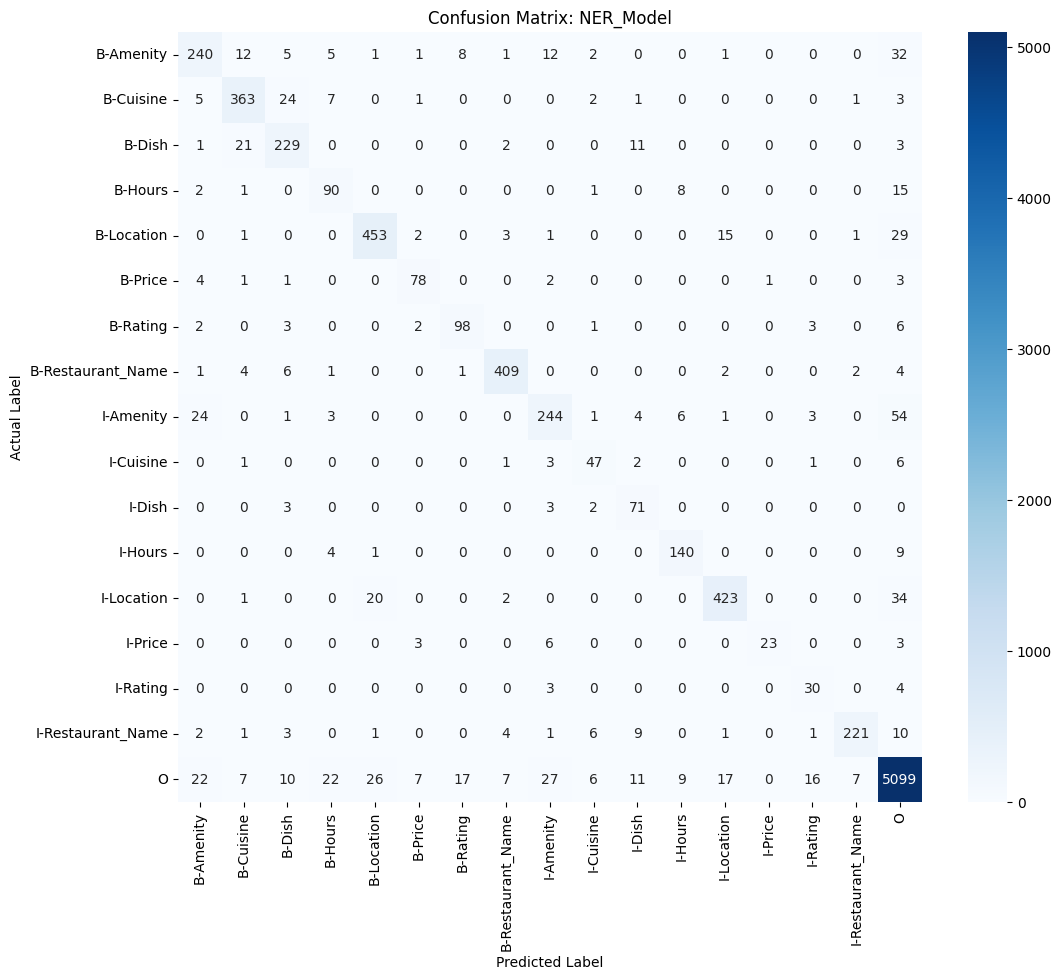

In [16]:
def plot_confusion_matrix(trainer, dataset, id2label, save_folder="evaluation/NER_Model"):
    predictions, labels, _ = trainer.predict(dataset)
    predictions = np.argmax(predictions, axis=2)

    
    true_labels_flat = [id2label[l] for label in labels for l in label if l != -100]
    pred_labels_flat = [id2label[p] for pred, label in zip(predictions, labels) for p, l in zip(pred, label) if l != -100]

    labels_list = sorted(list(set(true_labels_flat)))
    cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=labels_list)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_list, yticklabels=labels_list)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix: NER_Model')
    
    filename = "confusion_matrix.png"
    full_path = os.path.join(save_folder, filename)
    plt.savefig(full_path, bbox_inches='tight', dpi=300)

    plt.show()

plot_confusion_matrix(trainer, datasets["test"], id2label)

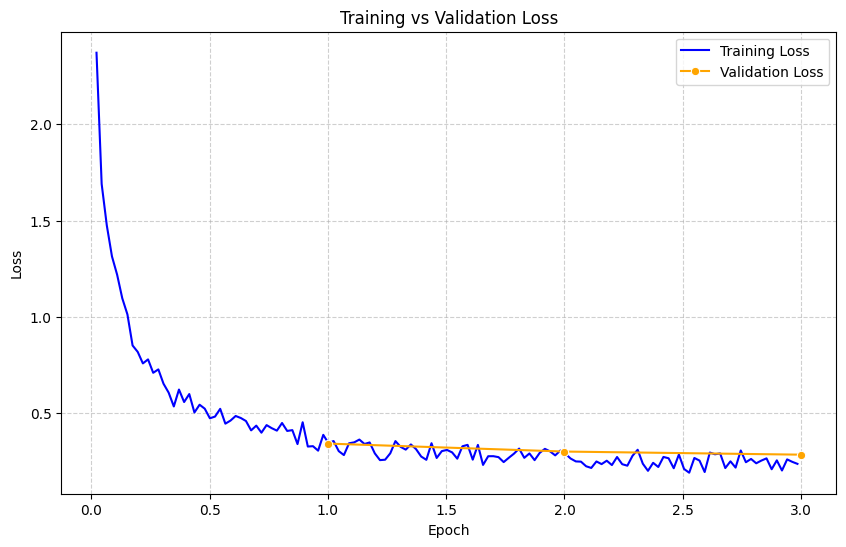

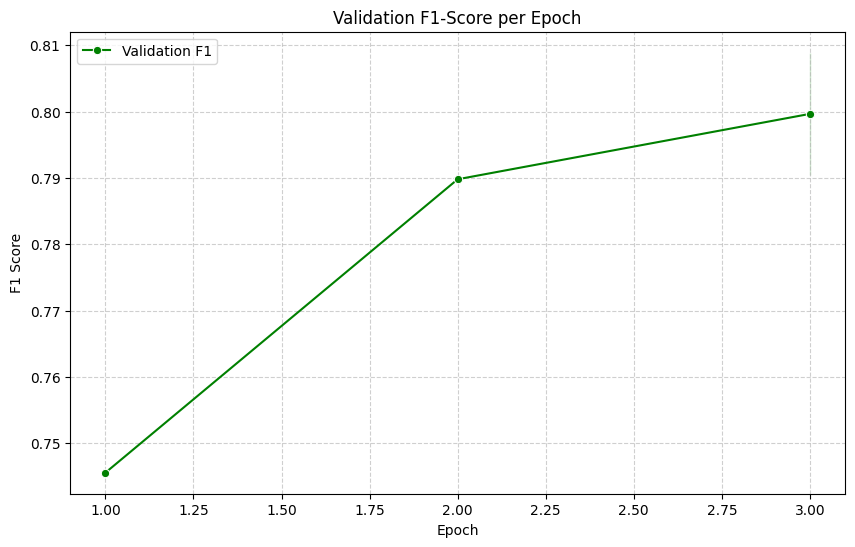

In [17]:
def plot_training_curves(trainer, save_folder="evaluation/NER_Model"):
    os.makedirs(save_folder, exist_ok=True)
    history = trainer.state.log_history
    
    train_log = []
    eval_log = []
    
    for entry in history:
        if 'loss' in entry: 
            train_log.append({
                'epoch': entry['epoch'],
                'loss': entry['loss'],
                'type': 'Training'
            })
        elif 'eval_loss' in entry:
            eval_log.append({
                'epoch': entry['epoch'],
                'loss': entry['eval_loss'],
                'f1': entry['eval_f1'], 
                'type': 'Validation'
            })
            
    df_train = pd.DataFrame(train_log)
    df_eval = pd.DataFrame(eval_log)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_train, x='epoch', y='loss', label='Training Loss', color='blue')
    sns.lineplot(data=df_eval, x='epoch', y='loss', label='Validation Loss', color='orange', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    loss_path = os.path.join(save_folder, "training_loss.png")
    plt.savefig(loss_path, bbox_inches='tight', dpi=300)
    plt.show()

    if 'f1' in df_eval.columns:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_eval, x='epoch', y='f1', color='green', marker='o', label='Validation F1')
        plt.title('Validation F1-Score per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        f1_path = os.path.join(save_folder, "validation_f1_curve.png")
        plt.savefig(f1_path, bbox_inches='tight', dpi=300)
        plt.show()

plot_training_curves(trainer)